## Terms for Use
Solvers are responsible for complying with all terms of use for the data sources they access.  All code in this document is provided using the [CC0 1.0 Universal (CC0 1.0) Public Domain Dedication](https://creativecommons.org/publicdomain/zero/1.0/).  The examples have been tested using Python 3 but have not been tested under Python 2.  Note that data providers may have changed their APIs or data formats after this notebook was published.

### Boring Details
The code cells below set up the notebook environment and load necessary libraries

In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.style.use("seaborn-dark")
import os

import pandas as pd
from dateutil.parser import parse # To convert strings to timestamps
GFC_HOME = os.path.abspath("../../..")
data_path = os.path.join(GFC_HOME, "data")

## [EMPRES](http://empres-i.fao.org/eipws3g/)

The Food and Agricultural Organization of the UN provides the EMPRES database, which is described by them:

EMPRES Global Animal Disease Information System (EMPRES-i) is a web-based application that has been designed to support veterinary services by facilitating the organization and access to regional and global disease information. Timely and reliable disease informa¬tion enhances early warning and response to transboundary and high impact animal diseases, including emergent zoonoses, and supports prevention, improved management and progressive approach to control.

### Example: African Swine Fever Cases in Ukraine
Although there is an all-purpose API for FAO it is probably easier to make selections on the main page and download a CSV of disease data.  The example below will walk through data downloaded on 18 April 2019.

First, we load the data into pandas and look at the columns.

In [3]:
empres_path = os.path.join(data_path, "EMPRES-i")
_filename = "Outbreak_list3030596102894508780.csv"
_path = os.path.join(empres_path, _filename)
outbreak_df = pd.read_csv(_path)
print(outbreak_df.columns)
outbreak_df.head()

Index(['Id', 'source', 'latitude', 'longitude', 'region', 'country', 'admin1',
       'localityName', 'localityQuality', 'observationDate', 'reportingDate',
       'status', 'disease', 'serotypes', 'speciesDescription', 'sumAtRisk',
       'sumCases', 'sumDeaths', 'sumDestroyed', 'sumSlaughtered',
       'humansGenderDesc', 'humansAge', 'humansAffected', 'humansDeaths'],
      dtype='object')


,Id,source,latitude,longitude,region,country,admin1,localityName,localityQuality,observationDate,...,speciesDescription,sumAtRisk,sumCases,sumDeaths,sumDestroyed,sumSlaughtered,humansGenderDesc,humansAge,humansAffected,humansDeaths
0,251603,OIE,-26.0000,28.7000,Africa,South Africa,Mpumalanga,"ASF_MPU_2019_001, Victor Kanye",Exact,15/04/2019,...,"domestic, swine",155.0,39.0,30.0,0.0,0.0,NaN,0.0,NaN,NaN
1,251605,OIE,48.4011,30.0663,Europe,Ukraine,Kirovohrads'ka,Berestiahy,Exact,14/04/2019,...,"wild, wild boar",NaN,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN
2,251525,OIE,49.6299,5.4270,Europe,Belgium,Region wallonne,Meix-devant-Virton,Exact,11/04/2019,...,"wild, wild boar",NaN,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
3,251524,OIE,49.6825,5.5533,Europe,Belgium,Region wallonne,Tintigny,Exact,11/04/2019,...,"wild, wild boar",NaN,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
4,251523,OIE,49.6827,5.5529,Europe,Belgium,Region wallonne,Tintigny,Exact,11/04/2019,...,"wild, wild boar",NaN,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN


Assuming that our objective is to get counts by time interval we can focus on a few columns:  `Id`, `country`, `observationDate`, `reportingDate`, `status`, `disease`, `sumCases`, `sumDeaths`.  We will also filter the data frame so that we only have events from Ukraine.

In [4]:
USE_COLS = ["Id", "country", "observationDate", "reportingDate", "status", "disease",
            "sumCases", "sumDeaths"]
outbreak_df = outbreak_df[USE_COLS]
outbreak_df = outbreak_df[outbreak_df["country"] == "Ukraine"]
print("There are {} rows of data".format(len(outbreak_df)))
outbreak_df.head()

There are 114 rows of data


,Id,country,observationDate,reportingDate,status,disease,sumCases,sumDeaths
1,251605,Ukraine,14/04/2019,18/04/2019,Confirmed,African swine fever,1.0,1.0
14,250707,Ukraine,09/04/2019,10/04/2019,Confirmed,African swine fever,4.0,4.0
23,250706,Ukraine,06/04/2019,09/04/2019,Confirmed,African swine fever,2.0,2.0
29,250698,Ukraine,03/04/2019,08/04/2019,Confirmed,African swine fever,2.0,2.0
67,249935,Ukraine,26/03/2019,28/03/2019,Confirmed,African swine fever,3.0,3.0


Note that the `observationDate` and `reportingDate` columns seem to be in the format dd/mm/yyyy.  We'd like to convert them to datetime objects using the `parse` function with `dayfirst=True` argument:

In [5]:
for col in ["observationDate", "reportingDate"]:
    outbreak_df[col] = outbreak_df[col].apply(parse, dayfirst=True)
outbreak_df.head()

,Id,country,observationDate,reportingDate,status,disease,sumCases,sumDeaths
1,251605,Ukraine,2019-04-14,2019-04-18,Confirmed,African swine fever,1.0,1.0
14,250707,Ukraine,2019-04-09,2019-04-10,Confirmed,African swine fever,4.0,4.0
23,250706,Ukraine,2019-04-06,2019-04-09,Confirmed,African swine fever,2.0,2.0
29,250698,Ukraine,2019-04-03,2019-04-08,Confirmed,African swine fever,2.0,2.0
67,249935,Ukraine,2019-03-26,2019-03-28,Confirmed,African swine fever,3.0,3.0


Notice that there's a several day difference between observation and reporting.  Let's look at the distribution of this reporting lag:

count    114.000000
mean       4.692982
std        3.805276
min        0.000000
25%        2.000000
50%        4.000000
75%        5.000000
max       19.000000
Name: reportingLag, dtype: float64


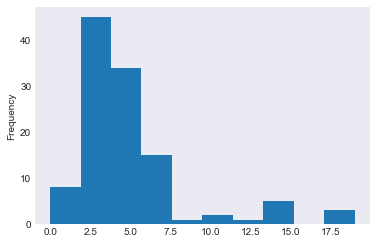

In [6]:
outbreak_df["reportingLag"] = (outbreak_df["reportingDate"] - outbreak_df["observationDate"]).apply(lambda x: x.days)
print(outbreak_df["reportingLag"].describe())
outbreak_df["reportingLag"].plot(kind="hist")

The median reporting lag is 4 days, with a minimum of 0 and a maximum of 19 days.

Now lets look at the number of cases by day

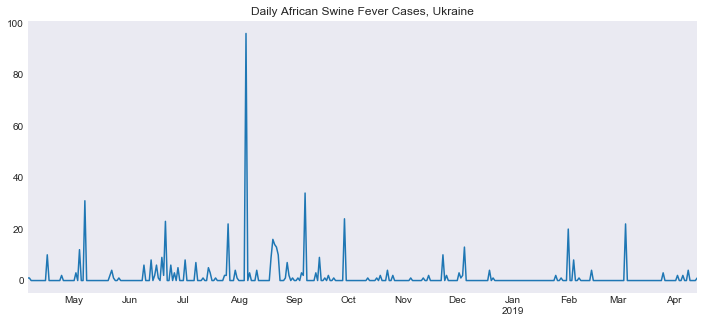

In [7]:
daily_case_ser = outbreak_df.groupby("observationDate").apply(lambda x: sum(x["sumCases"]))
_dr = pd.date_range(outbreak_df["observationDate"].min(), outbreak_df["observationDate"].max())
daily_case_ser = daily_case_ser.reindex(_dr).fillna(0)
daily_case_ser.plot(figsize=(12, 5), title="Daily African Swine Fever Cases, Ukraine")